# Importamos las librerias a usar

In [14]:
# !pip3 install --upgrade wandb

In [3]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import time

In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# import wandb
# from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
# wandb.login()

wandb: Currently logged in as: luisedu04 (luisedu04-buap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
lr = "NA" #Learning rate
epochs = 500
bs = "NA" #batch size
loss = "mse"
optimizer = "SDG"
regularizer = "NA"

In [13]:
# run = wandb.init(
#     settings=wandb.Settings(x_disable_stats=False, x_stats_sampling_interval = 1.0),
#     # set the wandb project where this run will be logged
#     name = "Primer_Intento",
#     project = "Creacion_de_regresion_lineal",
#     group = "ODE_SOLVER_A",

#     # track hyperparameters and run metadata with wandb.config
#     config = {
#         "layer_1": "100",
#         "layer_2": "20",
#         "layer_3": "1",
#         "activation_1_2": "tanh",
#         "activation_3": "linear",
#         "w_initializer": "He Initialization",
#         "optimizer": optimizer,
#         "loss": loss,
#         "metric": "mse",
#         "epoch": epochs,
#         "batch_size": bs,
#         "layer_quantity": 3,
#         "regularizer": regularizer,
#         "Modelo": "ODE"
#     }
# )
# time.sleep(3.0)

# Preparación

La solución de la ec. diferencial es y(x) = x*sen(x) - (2*sen(x))/x + 2*cos(x) + C/x, para valores muy pequeños de x tenemos y(x) = x^2 - 2x/x + 2 + C/x = x^2 + C/x si hacemos C = 0 entonces y(0) = 0 para valores pequeños de x. de otro modo en 0 la solución se va a infinito en 0. Ppor otro lado para evitar problemas de entrenamiento en la red aproximaremos el x_0<<1 y no a 0.

## Creamos la clase para resolver la ecuación diferencial

In [9]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy + y_pred - (x**2)*tf.cos(x) #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic = 0.00001 #valor que queremos para la condicion inicial o el modelo en x_0
             loss = self.mse(0., eq) + self.mse(y_o,ic)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

# Creación de la red neuronal

In [10]:
model = ODEsolver()
model.add(Dense(100, activation='tanh', input_shape=(1,)))
model.add(Dense(20, activation='tanh'))
model.add(Dense(1))
model.summary()

Model: "od_esolver"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

## Observamos el comportamiento del loss

Restoring model weights from the end of the best epoch: 490.


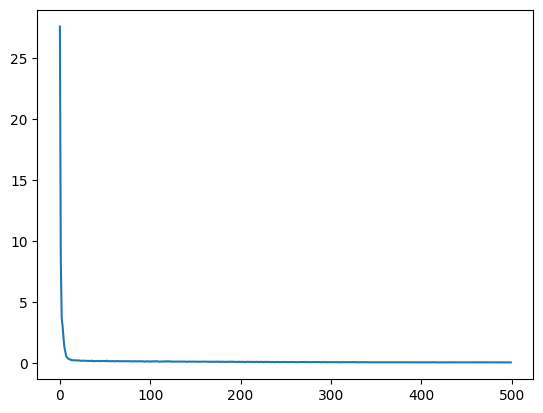

In [11]:
model.compile(optimizer=RMSprop(),metrics=['loss'])
divisions = 5000
x = tf.linspace(-5,5,divisions)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                               min_delta = 0.001,
                               patience=100, 
                               restore_best_weights=True,
                               mode = "auto",
                               verbose = 1,
                               baseline = None)
verbose = 0
history = model.fit(x, 
                    epochs = epochs, 
                    verbose = verbose, 
                    callbacks=[
                        # WandbMetricsLogger(log_freq=1),
                        # WandbModelCheckpoint("models/model.keras"),
                        early_stopping
                    ])
# run.finish()
plt.plot(history.history["loss"])

## Entrenamos el modelo y visualizamos

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


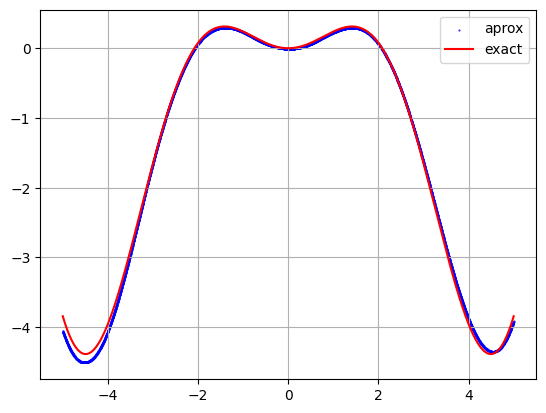

In [12]:
x_testv = tf.linspace(-5,5,divisions)
x = x_testv
a=model.predict(x_testv)
plt.scatter(x_testv,a,label="aprox", s = 0.2, color = "blue")
plt.plot(x_testv, x*np.sin(x)-(2*np.sin(x))/x + 2*np.cos(x),label="exact", color = "red")
plt.legend()
plt.grid()
plt.show()